In [2]:
from jax import  jacfwd
from jax import numpy as jnp, flatten_util, jit
import pylab as plt


# The Fisher Information for Gaussian gains

Here we assume that the gains likelihood is a complex normal distribution with uncorrelated errors.
The gain amplitudes are assumed to be unity and the phase is assumed to be a linear phase model consisting of a differential total electron content term and a constant (over frequency) phase offset.
The differential total electron content terms is called the ionospheric term, and this changes rapidly over time.
The phaes offset terms is called the systematic term is assumed not to change over time.


In [3]:
TEC_CONV = -8.4479745e6 #mTECU/Hz
freqs = jnp.linspace(121e6, 166e6, 24) #lofar HBA

@jit
def fisher_information(theta):

    flat_theta, unravel_theta = flatten_util.ravel_pytree(theta)

    def mean(flat_theta):
        theta = unravel_theta(flat_theta)
        tec = theta[0]
        const = theta[1]
        phase_mod = tec[:, None] * (TEC_CONV / freqs) + const
        Y = jnp.ravel(jnp.concatenate([jnp.cos(phase_mod), jnp.sin(phase_mod)], axis=-1))
        return Y

    def cov(flat_theta):
        theta = unravel_theta(flat_theta)
        sigma = theta[2]
        Sigma = sigma**2 * jnp.eye(2*freqs.size*theta[0].size)
        return Sigma


    Sigma = cov(flat_theta)#N,N
    dmudtheta = jacfwd(mean)(flat_theta)#N M
    I_mu = dmudtheta.T @ jnp.linalg.pinv(Sigma) @ dmudtheta

    dSigmadtheta = jacfwd(cov)(flat_theta)#N,N,M
    I_Sigma = 0.5*jnp.einsum("pj,jkn,kl,lpm->nm",
                             jnp.linalg.pinv(Sigma), dSigmadtheta, jnp.linalg.pinv(Sigma), dSigmadtheta)

    I = I_mu + I_Sigma
    return jnp.linalg.det(I)

# Best "experimental design" for differential total electron content inference

One way to formulate this question is to ask what is the best number of gains to bin together for inference of the constant (in time and frequency) systematic and the time-varying ionospheric term.
Intuitively one would guess that the more data which is binned together, the better, for inferring the constant systematic.
However this intuition is incorrect and hints at a deeper problem of modelling angular quantities.

Window size: 1, uncertainty: 0.35, FIM: 966.0947126456987
Window size: 2, uncertainty: 0.35, FIM: 2695.9925791036635
Window size: 3, uncertainty: 0.35, FIM: 4231.946867048674
Window size: 4, uncertainty: 0.35, FIM: 5248.759521485977
Window size: 5, uncertainty: 0.35, FIM: 5721.576346162977
Window size: 6, uncertainty: 0.35, FIM: 5748.005636015175
Window size: 7, uncertainty: 0.35, FIM: 5458.203962882642
Window size: 8, uncertainty: 0.35, FIM: 4973.620566471234
Window size: 9, uncertainty: 0.35, FIM: 4391.5384642508425
Window size: 10, uncertainty: 0.35, FIM: 3782.427983757304
Window size: 11, uncertainty: 0.35, FIM: 3192.971441228709
Window size: 12, uncertainty: 0.35, FIM: 2651.0086924072493
Window size: 13, uncertainty: 0.35, FIM: 2170.5728183160177
Window size: 14, uncertainty: 0.35, FIM: 1756.2353831909527


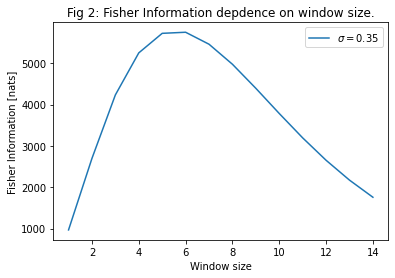

In [6]:
plt.figure(facecolor='white')
uncerts = [0.35, 0.4, 0.45, 0.5, 0.6]
window_sizes = list(range(1,15))
for uncert in uncerts:
    _I = []
    for n in window_sizes:
        simulated_tec = jnp.arange(n) * 20. # mTECU
        simulated_constant_systematic = jnp.asarray(1.) # radians
        theta = (simulated_tec, simulated_constant_systematic, uncert)  # M
        fim = fisher_information(theta)
        _I.append(fim)
        print(f"Window size: {n}, uncertainty: {uncert}, FIM: {fim}")
    _I = jnp.asarray(_I)
    _I -= _I.min()
    _I /= _I.max()
    plt.plot(window_sizes, _I, label=r'$\sigma={:.2f}$'.format(uncert))
plt.legend()
plt.xlabel('Window size')
plt.ylabel("Normalised Fisher Information")
plt.title("Fig 2: Fisher Information depdence on window size.")
plt.savefig("fim_vs_windowsize.png")
plt.show()

We see that the Fisher Information is not always larger, the more gains which are binned together, but rather depends on the scale of the gain noise.
In fact, there is a magical gain noise level of approximately 0.3 at which point it becomes progressively worse to bin gain data together.

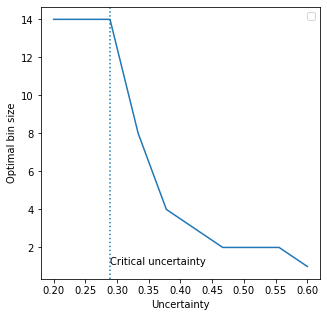

In [14]:
@jit
def get_best_window_size(uncert):
    window_sizes = jnp.asarray(list(range(1,15)))
    _I = []
    for n in window_sizes:
        simulated_tec = jnp.arange(n) * 20. # mTECU
        simulated_constant_systematic = jnp.asarray(1.) # radians
        theta = (simulated_tec, simulated_constant_systematic, uncert)  # M
        fim = fisher_information(theta)
        _I.append(fim)
    return window_sizes[jnp.argmax(jnp.asarray(_I))]


uncerts = jnp.linspace(0.2, 0.6, 10)
best_window = []
for uncert in uncerts:
    best_window.append(get_best_window_size(uncert))

threshold_idx = jnp.argmax(jnp.asarray(best_window[::-1]))
threshold = uncerts[-(threshold_idx+1)]

plt.figure(facecolor='white')
plt.plot(uncerts, best_window)
plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel("Optimal bin size")
plt.axvline(threshold, linestyle='dotted')
trans = plt.gca().get_xaxis_transform()
plt.text(threshold, .05, 'Critical uncertainty', transform=trans)
plt.savefig("best_window.png")
plt.show()

# Empirically observing this with Bayesian inference

In order to observe this effect on the accuracy of inference we apply Bayesian inference using JAXNS, and consider the posterior mean difference from the ground truth as a function of uncertainty, and window size.

Uncertainy: 0.25, window size: 1, Std(tec): 8.942552974782302
Uncertainy: 0.25, window size: 2, Std(tec): 9.111425532284754
Uncertainy: 0.25, window size: 3, Std(tec): 6.472553656218728
Uncertainy: 0.25, window size: 4, Std(tec): 5.5775733706537185
Uncertainy: 0.25, window size: 5, Std(tec): 14.463256536762449
Uncertainy: 0.25, window size: 6, Std(tec): 32.817007036041176
Uncertainy: 0.3, window size: 1, Std(tec): 13.458711415821451
Uncertainy: 0.3, window size: 2, Std(tec): 9.830212320859768
Uncertainy: 0.3, window size: 3, Std(tec): 6.296124162895916
Uncertainy: 0.3, window size: 4, Std(tec): 9.814023384125935
Uncertainy: 0.3, window size: 5, Std(tec): 22.873934731362436
Uncertainy: 0.3, window size: 6, Std(tec): 37.95172089356068
Uncertainy: 0.35, window size: 1, Std(tec): 12.384301973542218
Uncertainy: 0.35, window size: 2, Std(tec): 14.05329745976002
Uncertainy: 0.35, window size: 3, Std(tec): 12.593773493019405
Uncertainy: 0.35, window size: 4, Std(tec): 7.802876698543339
Uncerta

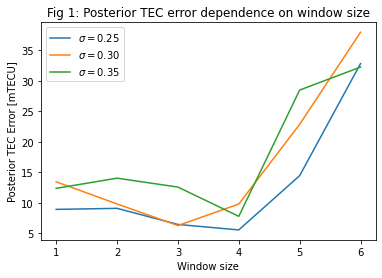

In [4]:
from jaxns.nested_sampling import NestedSampler, save_results, load_results
from jaxns.plotting import plot_diagnostics, plot_cornerplot
from jaxns.utils import summary, marginalise_static, resample, chunked_pmap
from jaxns.prior_transforms import UniformPrior, PriorChain, HalfLaplacePrior, DeltaPrior
import pylab as plt
from jax import numpy as jnp, random, flatten_util, jacfwd, tree_map, vmap
import os


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, n, uncert):
    """
    Generate gain data where the phase have a clock const and tec component, where the clock are shared for all data,
    and the tec are different:

    for i=1..n
        phase[i] = tec[i] * tec_conv + clock * clock_conv + const

    then the gains are:

        gains[i] = {cos(phase[i]), sin(phase[i])}

    Args:
        key:
        n: number of consequtive gains, i.e. tec values with shared const and clock terms.

    Returns:
        Y_obs, phase_obs, freqs
    """
    tec = jnp.arange(n)*10+100.
    const = 2.
    phase = tec[:, None] * (TEC_CONV / freqs) + const  # added a constant term
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    return Y_obs, tec, const, uncert

def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale)  - 0.5 * dx * dx

def solve(key, freqs, Y_obs, true_tec, true_const, true_uncert):
    window_size = Y_obs.shape[0]

    def log_likelihood(tec, const, uncert, **kwargs):
        phase = tec[:, None] * (TEC_CONV / freqs) + const
        Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
        logL = log_normal(Y, Y_obs, uncert)
        return jnp.sum(logL)

    prior_chain = PriorChain() \
        .push(UniformPrior('tec', -300. * jnp.ones(window_size), 300. * jnp.ones(window_size))) \
        .push(UniformPrior('const', -jnp.pi, jnp.pi)) \
        .push(HalfLaplacePrior('uncert', 0.5))

    # print("Probabilistic model:\n{}".format(prior_chain))

    def variance_tec(tec, const, uncert, **kwargs):
        return (tec - true_tec) ** 2

    def variance_const(tec, const, uncert, **kwargs):
        return (const - true_const) ** 2

    def variance_uncert(tec, const, uncert, **kwargs):
        return (uncert - true_uncert) ** 2


    ns = NestedSampler(log_likelihood,
                       prior_chain,
                       sampler_name='slice',
                       max_samples=1e6,
                       collect_samples=True,
                       marginalised=dict(var_tec=variance_tec,
                                         var_const=variance_const,
                                         var_uncert=variance_uncert)

                       )

    results = ns(key, 0.001)

    return results

uncerts = [0.25, 0.3, 0.35]
window_sizes = list(range(1, 7))
key = random.PRNGKey(42580594572)

plt.figure(facecolor='white')

collect_var = []
for uncert in uncerts:
    _tec_std = []
    for n in window_sizes:
        file_name = f'results_{uncert}_{n}.npz'
        key, sample_key = random.split(key, 2)
        Y_obs, true_tec, true_const, true_uncert = generate_data(sample_key, n, uncert)
        if not os.path.isfile(file_name):
            results = chunked_pmap(lambda key: solve(key, freqs, Y_obs, true_tec, true_const, true_uncert), random.split(key, 8))
            save_results(results, file_name)
        else:
            results = load_results(file_name)
        samples = vmap(lambda key, samples, log_p: resample(key,samples, log_p, S=2000))(
                           random.split(key, 8), results.samples, results.log_p)
        diff_tec = samples['tec'] - true_tec
        tec_std = jnp.sqrt(jnp.square(diff_tec).mean())
        print(f"Uncertainy: {uncert}, window size: {n}, Std(tec): {tec_std}")

        # (var_tec, var_const, var_uncert) = (jnp.sqrt(results.marginalised['var_tec']), jnp.sqrt(results.marginalised['var_const']),
        #           jnp.sqrt(results.marginalised['var_uncert']))
        # print(f"Uncertainty: {uncert}, window size: {n}, Variances: {(var_tec, var_const, var_uncert)}")
        # plot_diagnostics(results)
        # plot_cornerplot(results)
        # _tec_std.append(1./jnp.sqrt(results.marginalised['var_tec']).mean())
        _tec_std.append(tec_std)
    plt.plot(window_sizes, _tec_std, label=r'$\sigma={:.2f}$'.format(uncert))
plt.xlabel("Window size")
plt.ylabel("Posterior TEC Error [mTECU]")
plt.title("Fig 1: Posterior TEC error dependence on window size")
plt.legend()
plt.savefig("empirical.png")
plt.show()
